In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
import folium
from folium.plugins import HeatMap

# Data Analysis

In [ ]:
# Read the complete data
file_path = 'Crime_2024_with_Weather_Unemp_Monthly.xlsx'
df_interactive = pd.read_excel('Crime_2024_with_Weather_Unemp_Monthly.xlsx')


# Just add a request line, accelerated reading
usecols = [
    'date_of_occurrence', 'time_of_occurrence', 'area_name', 'crime_code_description',
    'victim_age', 'daily_precipitation_mm', 'daily_avg_temperature_celsius',
    'unemployment_rate_pct'
]

df = pd.read_excel(file_path, sheet_name='Sheet1', usecols=usecols)

# Change date format
df['date_of_occurrence'] = pd.to_datetime(df['date_of_occurrence'])
df['month'] = df['date_of_occurrence'].dt.to_period('M')

# No longer effective
df_valid_age = df[df['victim_age'] > 0]

### 1. Summary the dataset

In [3]:
# Summary dictionary
summary_stats = {
    'Total number of crimes': df.shape[0],
    'Mean victim age': df_valid_age['victim_age'].mean(),
    'Median victim age': df_valid_age['victim_age'].median(),
    'Victim age 25th percentile': df_valid_age['victim_age'].quantile(0.25),
    'Victim age 75th percentile': df_valid_age['victim_age'].quantile(0.75),
    'Average daily precipitation (mm)': df['daily_precipitation_mm'].mean(),
    'Average daily temperature (C)': df['daily_avg_temperature_celsius'].mean(),
    'Average unemployment rate (%)': df['unemployment_rate_pct'].mean()
}

# Print summary statistics
for k, v in summary_stats.items():
    print(f"{k}: {v:.2f}")

Total number of crimes: 127572.00
Mean victim age: 38.87
Median victim age: 36.00
Victim age 25th percentile: 27.00
Victim age 75th percentile: 49.00
Average daily precipitation (mm): 2.19
Average daily temperature (C): 16.71
Average unemployment rate (%): 5.70


We computed the mean, median, and percentiles for victim age to understand the age distribution of crime victims. Weather measures and unemployment rates were summarized because environmental and economic factors may influence crime trends. These statistics provide an overall picture of the key variables without being overwhelmed by raw data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get message (ensure the path is correct)
df = pd.read_excel('Crime_2024_with_Weather_Unemp_Monthly.xlsx')

# Unified format
sns.set_theme(style='whitegrid')

# Time standardization
df['date_of_occurrence'] = pd.to_datetime(df['date_of_occurrence'], errors='coerce')
df['month'] = df['date_of_occurrence'].dt.month

## 2.Crime quantity distribution area calculation

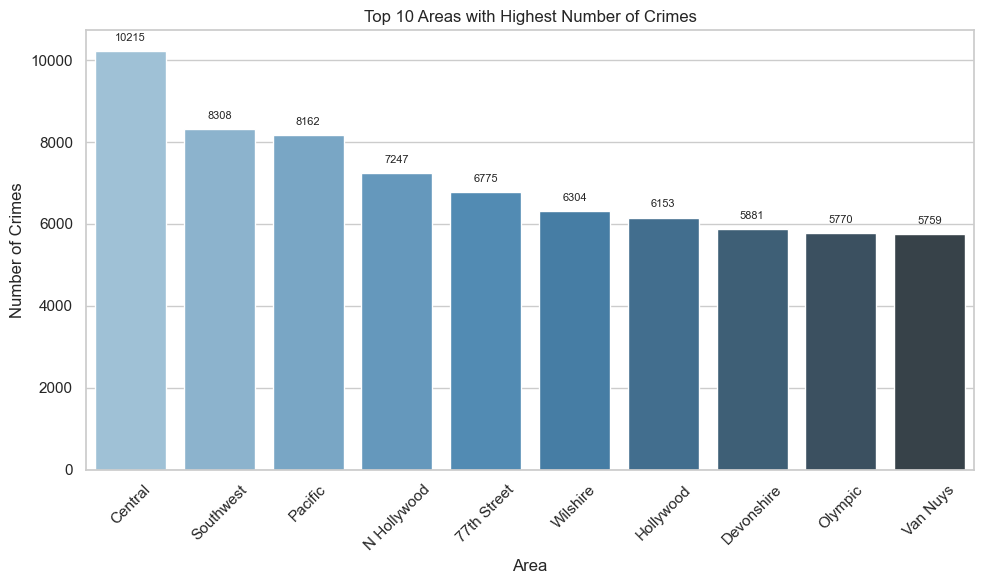

In [5]:
# [1. Crime quantity distribution area calculation - strip pattern]
# Get top 10 areas by crime count
top_areas = df['area_name'].value_counts().head(10).reset_index()
top_areas.columns = ['Area', 'crime_count']

plt.figure(figsize=(10,6))
sns.barplot(data=top_areas, x='Area', y='crime_count', hue='Area', palette='Blues_d', legend=False)
plt.xticks(rotation=45)
plt.title('Top 10 Areas with Highest Number of Crimes')
plt.xlabel('Area')
plt.ylabel('Number of Crimes')

for i, value in enumerate(top_areas['crime_count']):
    plt.text(i, value + 200, f'{value}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

The bar plot shows the Top 10 areas with the most crimes. Central has the highest crime count, and crime numbers gradually decline across areas.

Only the Top 10 areas are shown to focus on key regions. A dark-to-light blue color gradient highlights differences, and crime counts are labeled above each bar for clarity.

## 3. Monthly crime quantity calculation

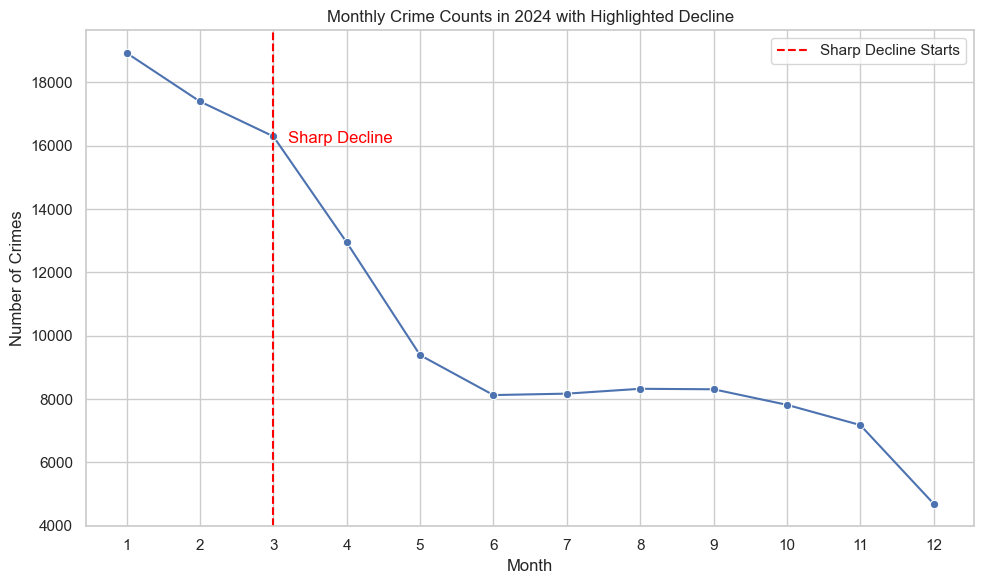

In [6]:
# [2. Monthly crime quantity calculation - record of crime]
# Generate monthly statistics
df_month = df.groupby('month').size().reset_index(name='crime_count')


plt.figure(figsize=(10,6))
sns.lineplot(data=df_month, x='month', y='crime_count', marker='o')
plt.xticks(ticks=range(1, 13))
plt.axvline(x=3, color='red', linestyle='--', label='Sharp Decline Starts')
plt.text(3.2, df_month['crime_count'].max()*0.85, 'Sharp Decline', color='red')
plt.title('Monthly Crime Counts in 2024 with Highlighted Decline')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The line plot shows monthly crime counts in Los Angeles for 2024.
A clear sharp decline starts after March, dropping from over 16,000 crimes to around 8,000 by June.
From June onward, crime levels remain relatively stable at a lower rate, with a slight drop again in December.
This pattern suggests a seasonal effect, with higher crime rates in early spring and much lower rates during summer and winter months.

## 4.Distribution of the previous 10 major crime categories

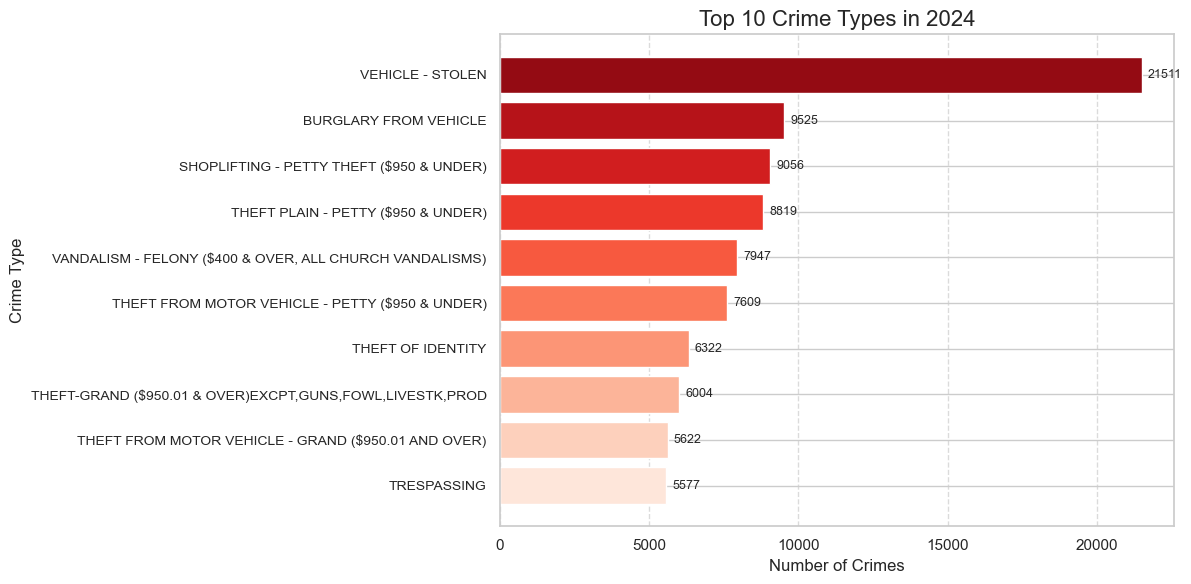

In [7]:
# [3. Distribution of the previous 10 major crime categories - strip pattern]
# Generate crime type quantity table
df_crime_type = df['crime_code_description'].value_counts().reset_index()
df_crime_type.columns = ['Crime Type', 'crime_count']

# Top 10
top_crimes = df_crime_type.sort_values('crime_count', ascending=False).head(10)

# plotting
fig, ax = plt.subplots(figsize=(12,6))
bars = ax.barh(y=top_crimes['Crime Type'], width=top_crimes['crime_count'], color=sns.color_palette('Reds_r', n_colors=10))
for bar in bars:
    width = bar.get_width()
    ax.text(width + 200, bar.get_y() + bar.get_height()/2,
            f'{int(width)}', va='center', fontsize=9)

ax.set_title('Top 10 Crime Types in 2024', fontsize=16)
ax.set_xlabel('Number of Crimes')
ax.set_ylabel('Crime Type')
plt.yticks(fontsize=10)
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The bar plot displays the Top 10 crime types in 2024. Vehicle theft is by far the most frequent crime, followed by burglary from vehicles and petty theft.

A red color gradient was applied to highlight differences. Exact crime counts are labeled next to each bar for clarity.

## 5. Interactive data widget：Top 3 Monthly Crime Types by Area

In [8]:
# Dropdown: select area
area_dropdown = widgets.Dropdown(
    options=sorted(df_interactive['area_name'].dropna().unique()),
    value='77th Street',
    description='Area:',
    layout=widgets.Layout(width='50%')
)

# function:update top 3 crime
def update_top3_crimes_by_month(area):
    # select area
    data = df_interactive[df_interactive['area_name'] == area].copy()

    #group by month,crime type
    grouped = data.groupby(['month', 'crime_code_description']).size().reset_index(name='count')

    #select Top 5 crime types
    top5_by_month = (
        grouped
        .sort_values(['month', 'count'], ascending=[True, False])
        .groupby('month')
        .head(3)
    )

    #bar chart
    fig = px.bar(
        top5_by_month,
        x='month',
        y='count',
        color='crime_code_description',
        title=f'Top 5 Crime Types by Month in {area}',
        labels={'count': 'Crime Count', 'month': 'Month', 'crime_code_description': 'Crime Type'},
        barmode='stack',
        height=500
    )

    fig.update_layout(
    title=f'Top 3 Crime Types by Month in {area}',
    xaxis=dict(dtick=1),
    yaxis=dict(title='Crime Count'),
    legend=dict(
        title='Crime Type',
        orientation='v',
        x=1.02,
        y=1
    ),
    margin=dict(r=160),
    height=500,
    width=1000,
    template='plotly_white'
)
    
    fig.show()

widgets.interact(update_top3_crimes_by_month, area=area_dropdown)

interactive(children=(Dropdown(description='Area:', layout=Layout(width='50%'), options=('77th Street', 'Centr…

<function __main__.update_top3_crimes_by_month(area)>

## 6.Interactive data widget：Monthly Crime Count with Temperature and Precipitation Trends

In [9]:
# Aggregate data groupby month
monthly = df_interactive.groupby('month').agg({
    'crime_code_description': 'count',
    'daily_avg_temperature_celsius': 'mean',
    'daily_precipitation_mm': 'mean'
}).reset_index()

#monthly crime count chart
fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthly['month'],
    y=monthly['crime_code_description'],
    name='Crime Count',
    yaxis='y1'
))

# average temperature chart
fig.add_trace(go.Scatter(
    x=monthly['month'],
    y=monthly['daily_avg_temperature_celsius'],
    name='Avg Temp (°C)',
    yaxis='y2',
    mode='lines+markers'
))

#average precipitation chart
fig.add_trace(go.Scatter(
    x=monthly['month'],
    y=monthly['daily_precipitation_mm'],
    name='Avg Precipitation (mm)',
    yaxis='y3',
    mode='lines+markers'
))

# add 1+3 axis
fig.update_layout(
    title='Monthly Crime Count, Avg Temperature, and Precipitation',

    # X months
    xaxis=dict(title='Month'),

    # Y1 crime count
    yaxis=dict(title='Crime Count', side='left', showgrid=False),

    # Y2 average temperature 
    yaxis2=dict(
        title='Avg Temp (°C)',
        overlaying='y',
        side='right',
        position=0.95
    ),

    # Y3 average precipitation 
    yaxis3=dict(
        title='Avg Precipitation (mm)',
        overlaying='y',
        side='right',
        position=1.0
    ),

    
    legend=dict(
        x=0.75,
        y=0.95,
        bgcolor='rgba(255,255,255,0.5)',
        bordercolor='gray',
        borderwidth=0.5
    ),
    margin=dict(t=50, b=40),
    template='plotly_white'
)

fig.show()

## 7. Average temperature vs. daily crime amount

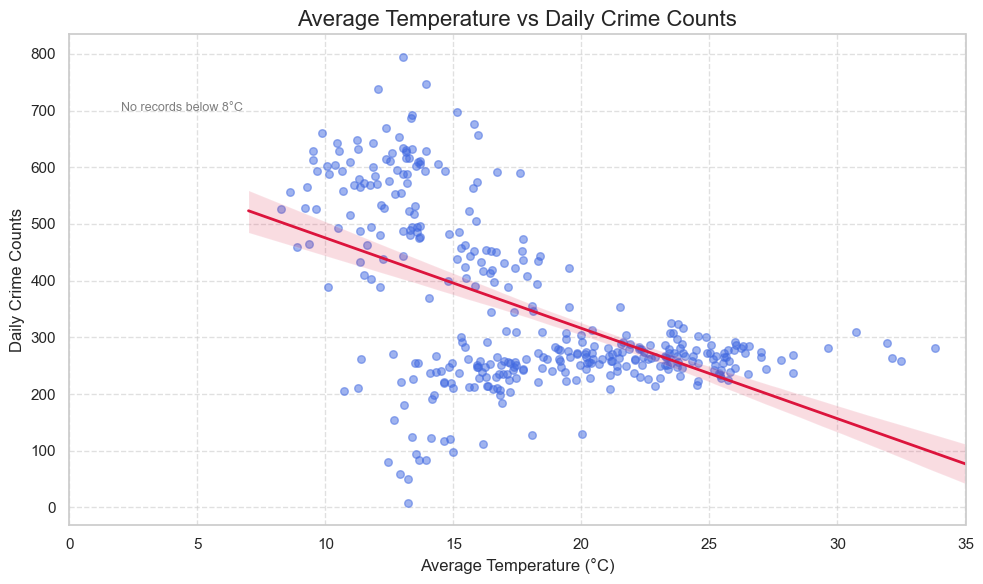

In [ ]:
# [4. Average temperature vs. daily crime amount - scattered pictures + circular]
# Create a column with just the date for grouping
df['date_only'] = df['date_of_occurrence'].dt.date

# Group by date to count total crimes per day
daily_crime_counts = df.groupby('date_only').size().reset_index(name='crime_count')

# Group by date to get average temperature per day
daily_temp = df.groupby('date_only')['daily_avg_temperature_celsius'].mean().reset_index()

# Merge crime and temperature data on date
daily_data = pd.merge(daily_crime_counts, daily_temp, on='date_only')

# Plotting the relationship
plt.figure(figsize=(10, 6))

sns.regplot(
    data=daily_data,
    x='daily_avg_temperature_celsius',
    y='crime_count',
    scatter_kws={'alpha': 0.5, 's': 30, 'color': 'royalblue'},  
    line_kws={'color': 'crimson', 'linewidth': 2},       
    truncate=False
)

# Customize appearance
plt.xlim(0, 35)
plt.title('Average Temperature vs Daily Crime Counts', fontsize=16)
plt.xlabel('Average Temperature (°C)', fontsize=12)
plt.ylabel('Daily Crime Counts', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Optional annotation for no-data region
plt.text(2, 700, 'No records below 8°C', color='gray', fontsize=9)

plt.tight_layout()
plt.show()

A scatter plot showing the relationship between average daily temperature and daily crime counts. Crime incidents generally decrease as temperatures rise.

A red regression line highlights the negative trend. A note marks that there are no records below 8°C, ensuring accurate data interpretation.

## 8. Weekend/Weekday Temperature vs Crime Quantity

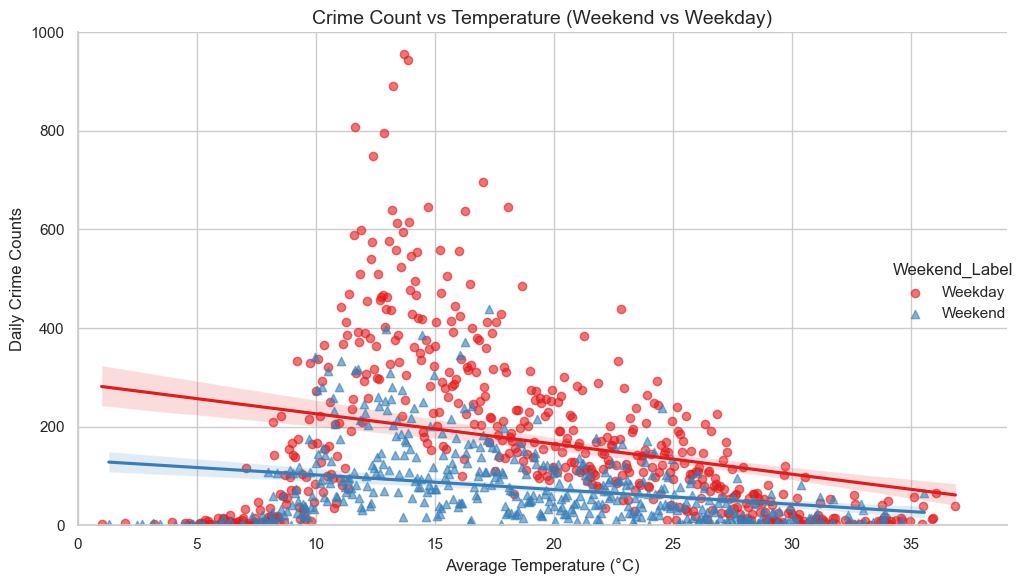

In [11]:
# [5. Weekend/Weekday Temperature vs Crime Quantity]
# Ensure 'is_weekend' exists
if 'is_weekend' not in df.columns:
    df['date_of_occurrence'] = pd.to_datetime(df['date_of_occurrence'], errors='coerce')
    df['dayofweek'] = df['date_of_occurrence'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Add a crime count column
df['crime_count'] = 1

# Group data by weekend status and temperature
grouped = df.groupby(['is_weekend', 'daily_avg_temperature_celsius']).agg({'crime_count':'sum'}).reset_index()

# Map 0/1 to clear labels
grouped['Weekend_Label'] = grouped['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})

# Create a scatterplot with regression lines
sns.lmplot(
    data=grouped,
    x='daily_avg_temperature_celsius',
    y='crime_count',
    hue='Weekend_Label',
    palette='Set1',
    aspect=1.5,
    height=6,
    markers=['o', '^'],
    scatter_kws={'alpha':0.6}  
)

# Perfect customizations
plt.title('Crime Count vs Temperature (Weekend vs Weekday)', fontsize=14)
plt.xlabel('Average Temperature (°C)', fontsize=12)
plt.ylabel('Daily Crime Counts', fontsize=12)
plt.ylim(0, 1000)
plt.xlim(0, 39)  
plt.grid(True)
plt.tight_layout()
plt.show()

This scatter plot compares the relationship between average temperature and daily crime counts on weekdays and weekends. Each point represents the total crime count for a given temperature. Regression lines show that crime rates are generally higher on weekdays, but both decrease as temperature rises. 

Different markers (circles and triangles) were used to distinguish weekdays and weekends more clearly.

## 9. Daily precipitation vs. daily crime amount

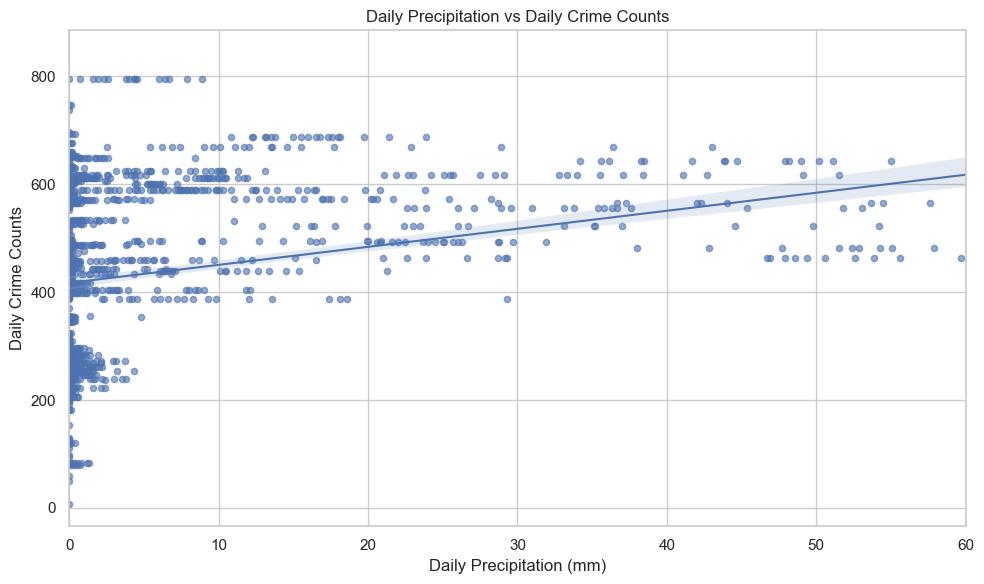

In [12]:
# [6. Daily precipitation vs. daily crime amount - scattered picture + circular]
# Merge crime count and daily precipitation
daily_crime_counts = daily_crime_counts.rename(columns={'date_only': 'date_of_occurrence'})
daily_crime_counts['date_of_occurrence'] = pd.to_datetime(daily_crime_counts['date_of_occurrence'])

daily_weather_precip = df[['date_of_occurrence', 'daily_precipitation_mm']].drop_duplicates()
daily_data_precip = pd.merge(daily_crime_counts, daily_weather_precip, on='date_of_occurrence')

plt.figure(figsize=(10, 6))
sns.regplot(
    x='daily_precipitation_mm',
    y='crime_count',
    data=daily_data_precip,
    scatter_kws={'alpha': 0.6, 's': 20},  # Smaller, more transparent dots
    line_kws={'linewidth': 1.5}
)

# Title and labels
plt.title('Daily Precipitation vs Daily Crime Counts')
plt.xlabel('Daily Precipitation (mm)')
plt.ylabel('Daily Crime Counts')
plt.xlim(0, 60)
plt.grid(True)
plt.tight_layout()
plt.show()

This scatter plot visualizes the relationship between daily precipitation and daily crime counts.Although most crimes occur when precipitation is low, the fitted regression line shows a slight positive trend, suggesting that crime counts tend to increase slightly with higher precipitation.

To emphasize clarity, the x-axis is limited to 0–60 mm to spread out the dense low-precipitation points, while the y-axis scale remains unchanged to maintain consistency across analyses.

## 10. Business failure rate vs. monthly crime volume

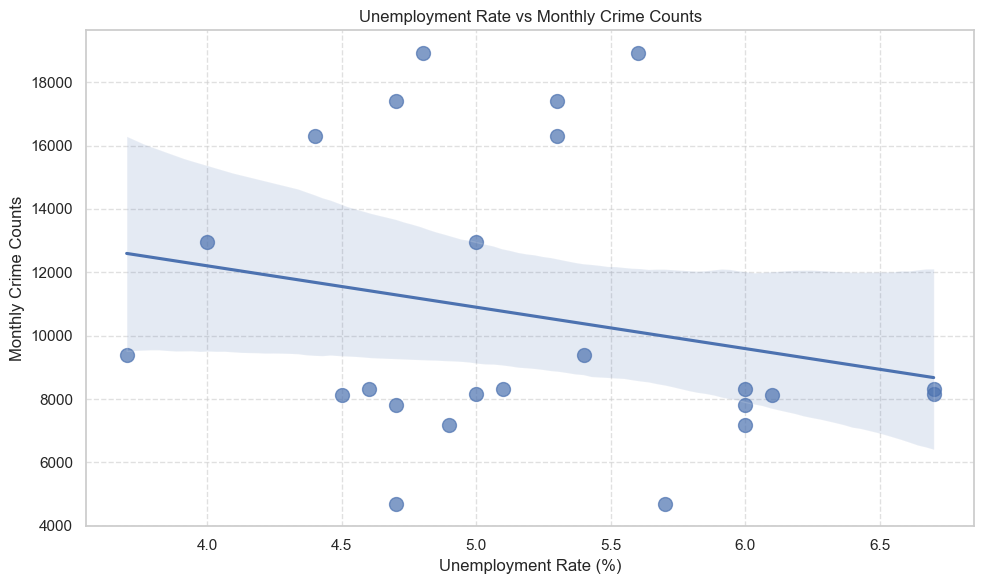

In [13]:
# [7. Business failure rate vs. monthly crime volume - scattered pictures + circular]
# Monthly loss rate (lost weight)
monthly_unemp = df[['month', 'unemployment_rate_pct']].drop_duplicates()

# Crime count per month
monthly_crimes = df.groupby('month').size().reset_index(name='crime_count')

# Merging
monthly_data = pd.merge(monthly_crimes, monthly_unemp, on='month')

plt.figure(figsize=(10, 6))
sns.regplot(x='unemployment_rate_pct', y='crime_count', data=monthly_data, scatter_kws={'alpha':0.7, 's':100})
plt.title('Unemployment Rate vs Monthly Crime Counts')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Monthly Crime Counts')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This plot examines the relationship between the unemployment rate and monthly crime counts. A slight negative trend is observed, suggesting that higher unemployment rates might be associated with lower crime counts. 

Brighter and slightly larger scatter points were used to improve visibility against the dark background.
The regression line with a 95% confidence interval provides a statistical insight into the negative relationship.

## 11. Crime type distribution by hour of day

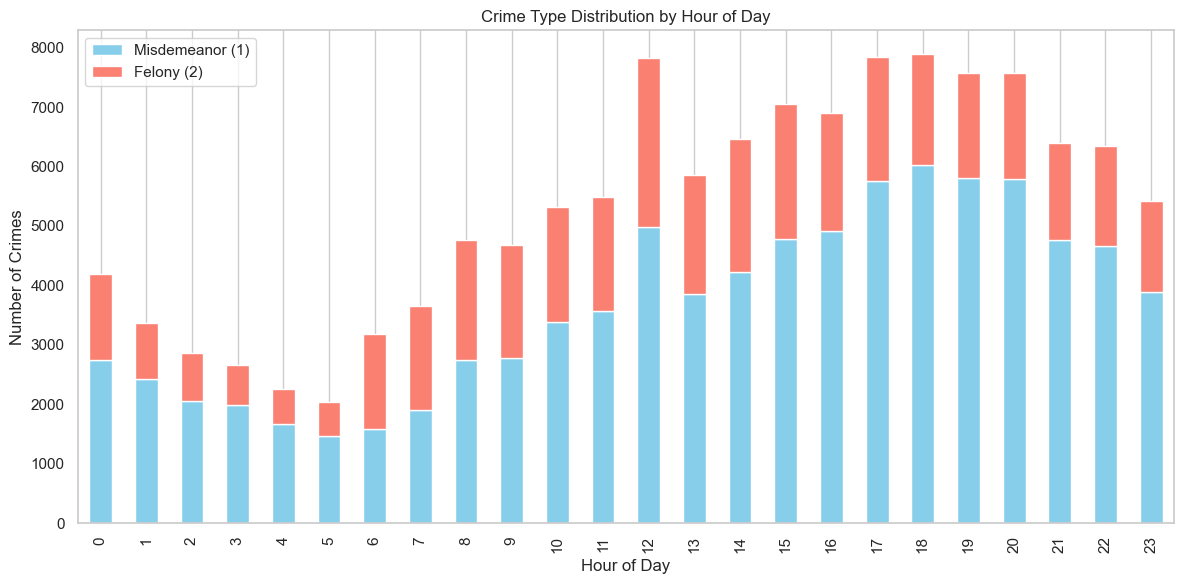

In [ ]:
# [8. Small time vs. crime type change]
# Ensure 'hour' column exists
if 'hour' not in df.columns:
    def extract_hour(x):
        try:
            x_str = str(int(x)).zfill(4)
            return int(x_str[:2])
        except:
            return np.nan
    df['hour'] = df['time_of_occurrence'].apply(extract_hour)

import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
df_hour = df[['hour', 'crime_part_category']].dropna()
df_hour['hour'] = df_hour['hour'].astype(int) 

# Amount of crime/felony amount
hour_crime_counts = df_hour.groupby(['hour', 'crime_part_category']).size().unstack(fill_value=0)

# Painted columnar diagram
hour_crime_counts.plot(kind='bar', stacked=True, figsize=(12,6), color=['skyblue', 'salmon'])
plt.title('Crime Type Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.xticks(range(0,24))
plt.legend(['Misdemeanor (1)', 'Felony (2)'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

A stacked bar chart showing the number of misdemeanors and felonies by hour of the day.
Crime counts increase throughout the day, peaking in late afternoon and evening.

## 12. Felony ratio by hour of day

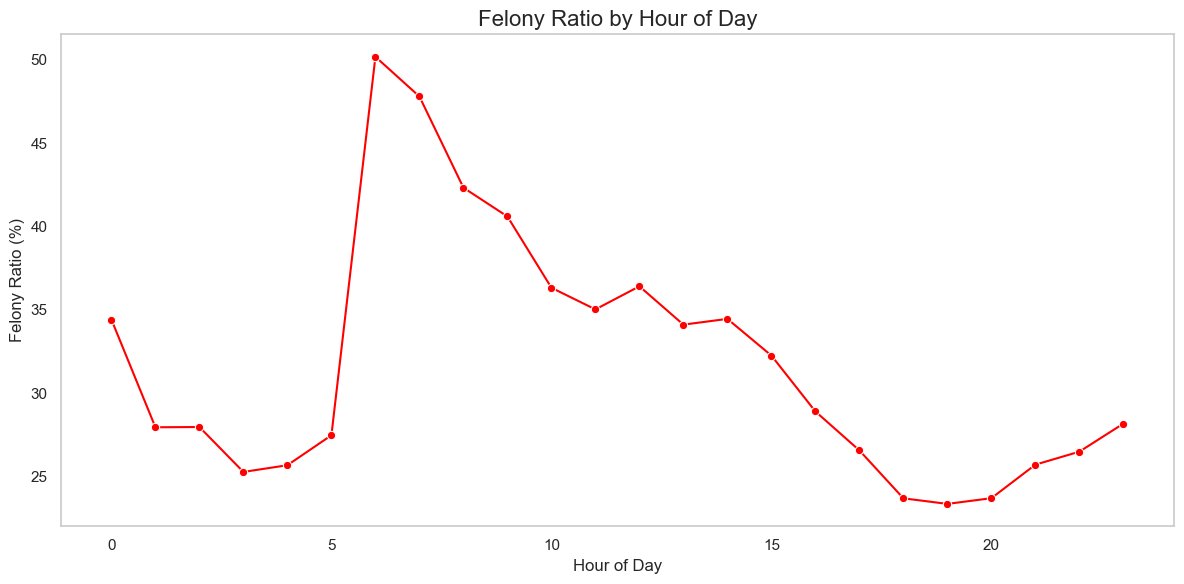

In [15]:
# [9. Transformation of felony]
hour_crime_counts['Felony Ratio (%)'] = hour_crime_counts[2] / (hour_crime_counts[1] + hour_crime_counts[2]) * 100
plt.figure(figsize=(12,6))
sns.lineplot(x=hour_crime_counts.index, y=hour_crime_counts['Felony Ratio (%)'], marker='o', color='red')
plt.title('Felony Ratio by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Felony Ratio (%)', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

A line chart showing the percentage of crimes that are felonies at each hour of the day.
Felony ratio is highest around early morning hours (around 6 AM) and lowest in the evening.